In [1]:
import pandas as pd
import pickle
import re
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2  # Added for feature selection
import numpy as np  # Added for potential optimizations


In [2]:
# -------------------------------
# Load Dataset
# -------------------------------
# Make the path configurable for better portability
dataset_path = r"C:/Users/arpan/PycharmProjects/AiChatbot/DiseaseAndSymptoms.csv"
df = pd.read_csv(dataset_path)

# -------------------------------
# Symptom Cleaning Function (Optimized)
# -------------------------------
# Compile regex patterns once for efficiency (avoids recompiling in loops)
intensity_pattern = re.compile(r"\b(mild|moderate|severe|high|low)\b")
non_alpha_pattern = re.compile(r"[^a-z ]")
whitespace_pattern = re.compile(r"\s+")

def clean_symptom(symptom):
    symptom = str(symptom).lower()
    symptom = symptom.replace("_", " ")
    symptom = intensity_pattern.sub("", symptom)
    symptom = non_alpha_pattern.sub("", symptom)
    symptom = whitespace_pattern.sub(" ", symptom).strip()
    return symptom

# -------------------------------
# Combine Symptom Columns (Vectorized)
# -------------------------------
symptom_cols = df.columns[1:]

# Use pandas apply with axis=1 for better performance on rows
df["symptoms"] = df[symptom_cols].apply(
    lambda row: [
        clean_symptom(s)
        for s in row
        if pd.notna(s) and clean_symptom(s)
    ],
    axis=1
)

# -------------------------------
# Remove Weak Records
# -------------------------------
df["symptom_count"] = df["symptoms"].apply(len)
df = df[df["symptom_count"] >= 2]

# -------------------------------
# Remove Rare Diseases (VERY IMPORTANT)
# -------------------------------
# Use pandas value_counts for efficiency instead of Counter
disease_counts = df["Disease"].value_counts()
COMMON_DISEASES = disease_counts[disease_counts >= 15].index

df = df[df["Disease"].isin(COMMON_DISEASES)]

# -------------------------------
# Encode Symptoms
# -------------------------------
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df["symptoms"])
y = df["Disease"]

# Optional: Feature Selection to Reduce Dimensionality (Improves Efficiency)
# Select top K features based on chi-squared test (adjust K as needed, e.g., 100-500)
# This reduces the number of features, speeding up training without much loss in accuracy
k_features = min(500, X.shape[1])  # Cap at 500 or less if fewer features
selector = SelectKBest(chi2, k=k_features)
X = selector.fit_transform(X, y)



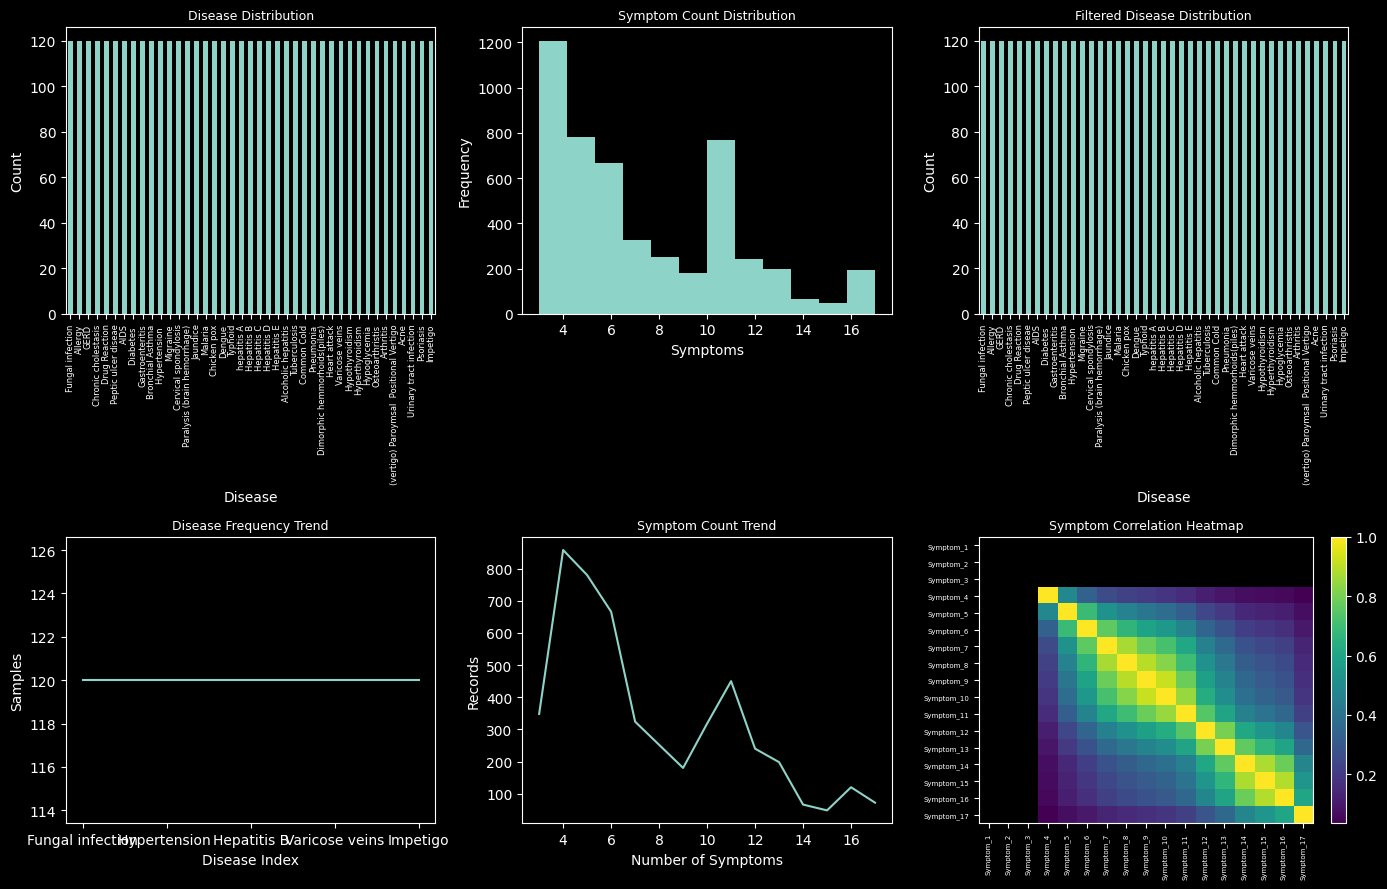

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv(r"C:/Users/arpan/PycharmProjects/AiChatbot/DiseaseAndSymptoms.csv")

# Prepare symptom count
symptom_cols = df.columns[1:]
df["symptom_count"] = df[symptom_cols].notna().sum(axis=1)

# Filter common diseases
disease_counts = df["Disease"].value_counts()
common_diseases = disease_counts[disease_counts >= 15].index
df_filtered = df[df["Disease"].isin(common_diseases)]

# Encode symptoms for correlation (binary presence)
symptom_binary = df_filtered[symptom_cols].notna().astype(int)

# Correlation matrix
corr_matrix = symptom_binary.corr()

# ---------------- BOXED VISUALIZATION WITH HEATMAP ----------------
plt.figure(figsize=(14, 9))

# 1️⃣ Disease Distribution
plt.subplot(2, 3, 1)
df["Disease"].value_counts().plot(kind="bar")
plt.title("Disease Distribution", fontsize=9)
plt.xticks(rotation=90, fontsize=6)
plt.ylabel("Count")

# 2️⃣ Symptom Count Distribution
plt.subplot(2, 3, 2)
plt.hist(df["symptom_count"], bins=12)
plt.title("Symptom Count Distribution", fontsize=9)
plt.xlabel("Symptoms")
plt.ylabel("Frequency")

# 3️⃣ Filtered Disease Distribution
plt.subplot(2, 3, 3)
df_filtered["Disease"].value_counts().plot(kind="bar")
plt.title("Filtered Disease Distribution", fontsize=9)
plt.xticks(rotation=90, fontsize=6)
plt.ylabel("Count")

# 4️⃣ Line Graph: Disease Frequency Trend
plt.subplot(2, 3, 4)
disease_counts.sort_values().plot()
plt.title("Disease Frequency Trend", fontsize=9)
plt.xlabel("Disease Index")
plt.ylabel("Samples")

# 5️⃣ Line Graph: Symptom Count Trend
plt.subplot(2, 3, 5)
df["symptom_count"].value_counts().sort_index().plot()
plt.title("Symptom Count Trend", fontsize=9)
plt.xlabel("Number of Symptoms")
plt.ylabel("Records")

# 6️⃣ Heatmap: Symptom Correlation
plt.subplot(2, 3, 6)
plt.imshow(corr_matrix, aspect="auto")
plt.title("Symptom Correlation Heatmap", fontsize=9)
plt.colorbar(fraction=0.046)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=5)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=5)

plt.tight_layout()
plt.show()


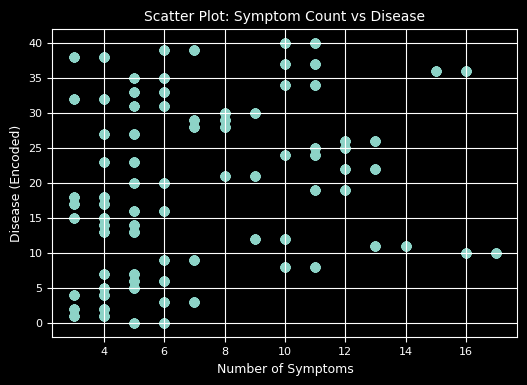

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r"C:/Users/arpan/PycharmProjects/AiChatbot/DiseaseAndSymptoms.csv")

# Count symptoms per record
symptom_cols = df.columns[1:]
df["symptom_count"] = df[symptom_cols].notna().sum(axis=1)

# Encode disease labels numerically for scatter plot
df["disease_code"] = df["Disease"].astype("category").cat.codes

# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(df["symptom_count"], df["disease_code"])
plt.title("Scatter Plot: Symptom Count vs Disease", fontsize=10)
plt.xlabel("Number of Symptoms", fontsize=9)
plt.ylabel("Disease (Encoded)", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)

plt.show()

In [5]:
# -------------------------------
# Train / Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Train Safer Model (Optimized)
# -------------------------------
# Reduce n_estimators if training is too slow (e.g., from 400 to 200), and add n_jobs for parallelism
model = RandomForestClassifier(
    n_estimators=200,  # Reduced for speed; increase if accuracy is prioritized over time
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1  # Use all available CPU cores for parallel training
)

model.fit(X_train, y_train)

# -------------------------------
# Evaluate Model Accuracy
# -------------------------------
# Calculate accuracy on the test set
accuracy = model.score(X_test, y_test)
print(f"✅ Model Accuracy on Test Set: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# -------------------------------
# Save Model & Encoder
# -------------------------------
# Make paths configurable
model_path = r"C:/Users/arpan/PycharmProjects/AiChatbot/Models/disease_model.pkl"
encoder_path = r"C:/Users/arpan/PycharmProjects/AiChatbot/Models/symptom_encoder.pkl"
selector_path = r"C:/Users/arpan/PycharmProjects/AiChatbot/Models/feature_selector.pkl"  # Save selector if using feature selection

pickle.dump(model, open(model_path, "wb"))
pickle.dump(mlb, open(encoder_path, "wb"))
if 'selector' in locals():  # Save selector only if feature selection was applied
    pickle.dump(selector, open(selector_path, "wb"))

print("✅ Optimized model trained & saved successfully")

✅ Model Accuracy on Test Set: 1.0000 (100.00%)
✅ Optimized model trained & saved successfully
